In [1]:
import os
import sys
# Construct the path to the directory you want to import from
# '..' goes up one directory level. Adjust as needed.
module_path = os.path.abspath(os.path.join('..'))

# Add the directory to sys.path
if module_path not in sys.path:
    sys.path.append(module_path)


from gridworld_env_layout import GridWorldMDPFromLayoutEnv
from gridworld_env import NoisyLinearRewardFeaturizedGridWorldEnv
import numpy as np

from agent.q_learning_agent import ValueIteration, PolicyEvaluation
from scipy.optimize import linprog

from utils.machine_teaching_utils import (build_Pi_from_q,
compute_successor_features_iterative_from_q,
 derive_constraints_from_q_ties, 
 remove_redundant_constraints,
 generate_candidates_from_q,
 plot_halfspace_intersection_2d)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


### Making different mdps

In [10]:
# --- Build your 2x3 env (no rendering) ---

W_TRUE = np.array([-10, -2])/np.linalg.norm([-10, -2])

layout = [
    ["blue",  "red", "blue"],
    ["blue", "blue",  "blue"],
]


color_to_feature_map = {
    "red":  [1.0, 0.0],
    "blue": [0.0, 1.0],
}
rows, cols = 2, 3

env_1 = GridWorldMDPFromLayoutEnv(
    gamma=0.99,
    layout=layout,
    color_to_feature_map=color_to_feature_map,
    noise_prob=0,
    terminal_states=[0],
    custom_feature_weights=W_TRUE,
    render_mode=None,
)

env_2 = GridWorldMDPFromLayoutEnv(
    gamma=0.99,
    layout=layout,
    color_to_feature_map=color_to_feature_map,
    noise_prob=0,
    terminal_states=[],
    custom_feature_weights=W_TRUE,
    render_mode=None,
)

envs = [env_1, env_2]

vis = [ValueIteration(env) for env in envs]

envs_V = [vi.run_value_iteration(epsilon=1e-10) for vi in vis]

envs_Q = [vi.get_q_values() for vi in vis]

In [11]:
def build_Pi_from_q_family(envs, Q_list, tie_eps=1e-10):
    Pis = []
    for env, q in zip(envs, Q_list):
        Pis.append(build_Pi_from_q(env, q, tie_eps=tie_eps))
    return Pis

def compute_successor_features_family(envs, Q_list, **kw):
    out = []
    for env, q in zip(envs, Q_list):
        mu_sa, mu_s, Phi, P_pi = compute_successor_features_iterative_from_q(env, q, **kw)
        out.append((mu_sa, mu_s, Phi, P_pi))
    return out

def derive_constraints_family(SFs, Q_list, envs, tie_eps=1e-10,
                              skip_terminals=True, normalize=True, tol=1e-12,
                              precision=1e-3, lp_epsilon=1e-4):
    U_per_mdp = []
    all_H = []
    for (mu_sa, _, _, _), q, env in zip(SFs, Q_list, envs):
        cons = derive_constraints_from_q_ties(mu_sa, q, env,
                                              tie_eps=tie_eps,
                                              skip_terminals=skip_terminals,
                                              normalize=normalize, tol=tol)
        H_i = [c[0] if isinstance(c, tuple) else c for c in cons]  # keep vectors
        U_per_mdp.append(H_i)
        all_H.extend(H_i)

    # spherical dedup by cosine threshold
    pre = []
    for v in all_H:
        if not any(np.dot(v, u) / (np.linalg.norm(v)*np.linalg.norm(u)) > 1-precision for u in pre):
            pre.append(v)

    # LP redundancy removal on the family set (your existing routine)
    U_global = np.array(remove_redundant_constraints(pre, epsilon=lp_epsilon))
    return U_per_mdp, U_global

def generate_candidates_from_q_family(envs, Q_list, **kw):
    C = []
    for env, q in zip(envs, Q_list):
        C.append(generate_candidates_from_q(env, q, **kw))
    return C

def scot_greedy_family_unweighted(
    U_global,       # np.ndarray of unit normals in R^d (family universe)
    candidates,     # List[List[Traj]] per MDP: candidates[i] = list of trajectories for MDP i
    SFs,            # List[(mu_sa, mu_s, Phi, P_pi)] per MDP; we use mu_sa only
    normalize=True,
    round_decimals=12,
):
    """
    Unweighted greedy set cover over family constraints.
    Returns:
        chosen: List[(mdp_index, trajectory)] until U_global is covered or no progress possible.
    """
    m = len(candidates)
    mu_sa_list = [sf[0] for sf in SFs]  # (S_i, A_i, d)

    # stable key for a direction vector
    def key_for(v):
        n = np.linalg.norm(v)
        if not np.isfinite(n) or n == 0.0:
            return ("ZERO",)
        vv = v / n if normalize else v
        return tuple(np.round(vv, round_decimals))

    # index universe by direction key
    key_to_uix = {}
    for idx, v in enumerate(U_global):
        key_to_uix.setdefault(key_for(v), []).append(idx)

    universe = set(range(len(U_global)))
    covered  = set()
    chosen   = []

    # precompute coverage set for each candidate trajectory (against U_global)
    cov = [[set() for _ in cand_i] for cand_i in candidates]
    for i, (cand_i, mu_sa) in enumerate(zip(candidates, mu_sa_list)):
        S_i, A_i, _ = mu_sa.shape
        for j, tau in enumerate(cand_i):
            covered_by_tau = set()
            for (s, a) in tau:
                psi_star = mu_sa[s, a]
                for b in range(A_i):
                    if b == a:
                        continue
                    v = psi_star - mu_sa[s, b]
                    k = key_for(v)
                    if k in key_to_uix:
                        covered_by_tau.update(key_to_uix[k])
            cov[i][j] = covered_by_tau

    # greedy loop: pick the candidate with the largest new coverage
    while True:
        uncovered = universe - covered
        if not uncovered:
            break

        best_gain = 0
        best_item = None
        best_new  = None

        for i in range(m):
            for j in range(len(candidates[i])):
                if not cov[i][j]:
                    continue
                new_cover = uncovered & cov[i][j]
                gain = len(new_cover)
                if gain > best_gain:
                    best_gain, best_item, best_new = gain, (i, j), new_cover

        if best_item is None:  # no candidate adds new coverage
            break

        i, j = best_item
        chosen.append((i, candidates[i][j]))
        covered |= best_new

    return chosen

In [12]:
# --- 1) Successor features per MDP (from Q) ---
SFs = compute_successor_features_family(
    envs,
    envs_Q,
    convention="entering",
    zero_terminal_features=True,
    tol=1e-10,
    max_iters=10000,
)

# --- 2) Constraints: per-MDP and family (FBEC) ---
U_per_mdp, U_global = derive_constraints_family(
    SFs,
    envs_Q,
    envs,
    tie_eps=1e-10,
    skip_terminals=True,
    normalize=True,
    tol=1e-12,
    precision=1e-3,
    lp_epsilon=1e-4,
)

# (Optional) If you want to quickly visualize constraints before demos:
# my_visualize_constraints(U_per_mdp=U_per_mdp, U_global=U_global, envs=envs)



Pi from q:  [[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
Pi from q:  [[0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.25       0.25       0.25       0.25      ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.25       0.25       0.25       0.25      ]]


[[-1.       -0.336689]
 [-0.       -0.      ]
 [-1.       -0.      ]]


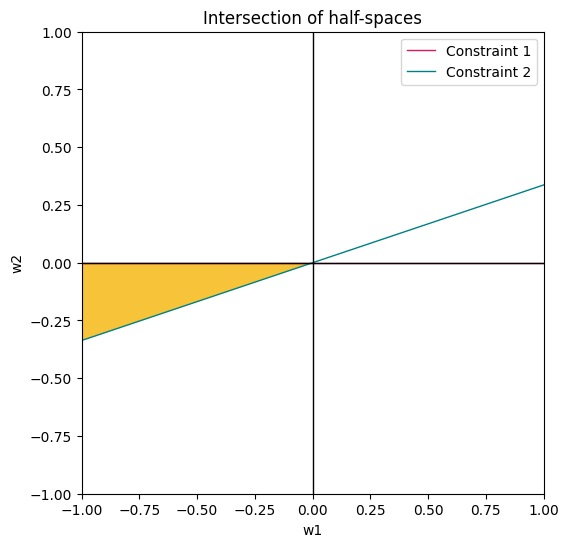

In [13]:
plot_halfspace_intersection_2d(U_global)

[[-1.       -0.336689]
 [-0.       -0.      ]
 [-1.       -0.      ]]


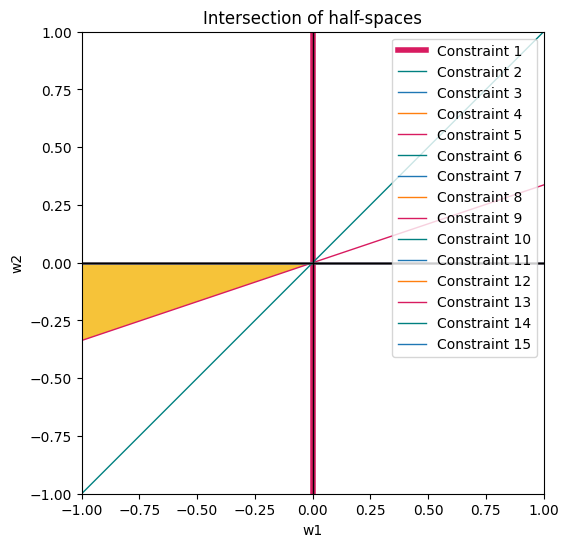

In [14]:
plot_halfspace_intersection_2d(U_per_mdp[0])

[[-1. -1.]
 [ 1.  1.]
 [-1.  1.]]


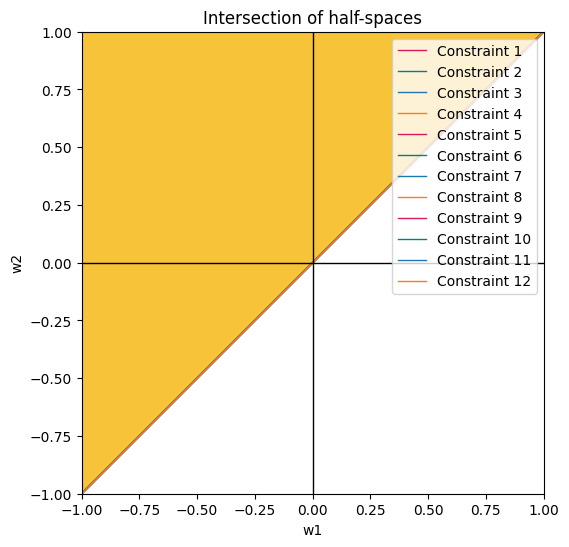

In [15]:
plot_halfspace_intersection_2d(U_per_mdp[1])

In [8]:

# --- 3) Candidate demos per MDP (greedy policy rollouts from Q) ---
candidates = generate_candidates_from_q_family(
    envs,
    envs_Q,
    num_rollouts_per_state=5,   # adjust as you like
    max_steps=12,
    tie_eps=1e-10,
)

# --- 4) Unweighted greedy cover over family constraints ---
chosen = scot_greedy_family_unweighted(
    U_global=U_global,
    candidates=candidates,
    SFs=SFs,
    normalize=True,
    round_decimals=12,
)
# chosen is: List[(mdp_index, trajectory_list_of_(s,a))]
# Example: [(0, [(s0,a2), (s5,a1), ...]), (1, [...]), ...]

starting state:  0
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
starting state:  0
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2, 3]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2, 3]
optimal actions:  [0, 1, 2, 3]
optimal actions:  [0, 1, 2, 3]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2, 3]
starting state:  0
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2]
optimal actions:  [0, 1, 2, 3]
optimal actions:  [0, 1, 2, 3]
optimal actions:  [1, 2, 3]
optimal actions:  [0, 1, 2, 3]
optimal actions:  [0, 1, 2, 3]
optimal actions:  [0, 1, 2, 3]
optimal actions: 

In [9]:
chosen

[(0,
  [(0, 0),
   (0, 0),
   (0, 2),
   (0, 2),
   (0, 2),
   (0, 2),
   (0, 2),
   (0, 0),
   (0, 0),
   (0, 0),
   (0, 2),
   (0, 1)]),
 (1, [(0, 3)])]